In [1]:
import torch.nn.functional as F
import torch
from torch import nn
from dataset import BratsDataset
from training_loop import train_model
from basic_unet import UNet
from torchvision import transforms
from pathlib import Path
from torch.utils.data import DataLoader
from torch import optim
import matplotlib.pyplot as plt
from rise import RISE

In [2]:
batch_size = 1

def load_dataset():
    transform = transforms.Compose([])
    train_dataset = BratsDataset(Path('data/processed'), transform=transform, test=False)
    test_dataset = BratsDataset(Path('data/processed'), transform=transform, test=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    return train_loader, test_loader

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_loader, test_loader = load_dataset()
model = UNet(in_channels=4, out_channels=1)
state_dict = torch.load('models/3_basic_unet_flat_criterion_279_0.00000.pth')
model.load_state_dict(state_dict)
model = model.to(device)

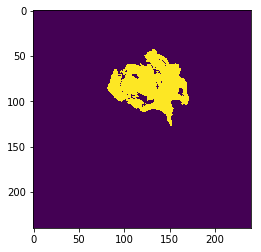

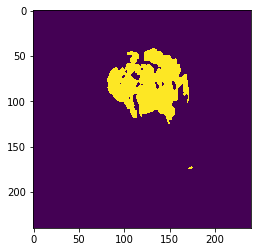

In [4]:
sample = next(iter(test_loader))

segment = sample['segment']
segment = segment.squeeze()
plt.imshow(segment)
plt.show()

image = sample['input'].to(device)
output = model(image)
output = output.detach().cpu().squeeze().numpy()
output = (output > output.mean())
plt.imshow(output)
plt.show()

In [5]:
class SegmentationRISE(RISE):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        mask_count = self.N
        _, _, H, W = x.size()

        # generate new images by putting mask on top of original image
        stack = torch.mul(self.masks, x.data)

        output = model(x).squeeze()
        output = (output > output.mean())
        for x in range(output.shape[0]):
            for y in range(output.shape[1]):
                if output[x][y]:
                    # run generated images through the model
                    p = []
                    for i in range(0, mask_count, self.gpu_batch):
                        output_mask = self.model(stack[i:min(i + self.gpu_batch, mask_count)])
                        single_pixel = output_mask[0][x][y]
                        single_pixel = single_pixel.unsqueeze(0).unsqueeze(0)
                        p.append(single_pixel)
                    p = torch.cat(p)

                    # Number of classes
                    CL = p.size(1)

                    sal = torch.matmul(p.data.transpose(0, 1), self.masks.view(mask_count, H * W))

                    sal = sal.view((CL, H, W))
                    sal /= mask_count
                    return sal

masks_path = Path('rise_masks.npy')
explainer = SegmentationRISE(model, (240, 240), batch_size)
if not masks_path.exists():
    explainer.generate_masks(N=3000, s=8, p1=0.1, savepath=masks_path)
else:
    explainer.load_masks(masks_path)

with torch.set_grad_enabled(False):    
    saliency = explainer(image).cpu().numpy()

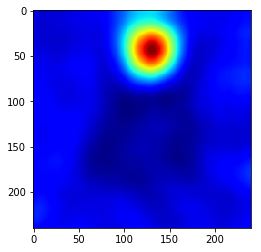

In [6]:
plt.imshow(saliency[0], cmap='jet')
plt.show()